# This notebook includes some examples of plotting and computing statistics that are described in the workflow paper

## Section 1: Computing statistics
The processes in this section are similar to notebook ensemble(mean)_TempPrecip(change)_more_options. See there for detailed description.

## Section 2: North African monsoon (NAF) expansion in the midHolocene and lig127k than the piControl
## Section 3: Changes in NAF (midHolocene - piControl)

In [18]:
# import packages
import matplotlib.pyplot as plt
import xarray as xr
import xesmf as xe
import numpy as np
%matplotlib inline
import cartopy
import cartopy.crs as ccrs
import matplotlib
from netCDF4 import Dataset
import matplotlib.colors as colors
from matplotlib import gridspec 
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pandas as pd
from global_land_mask import globe

In [8]:
# CMIP6 colours
# each file has 7 columns:
#  "model": model names
#  "ncl_<R,G,B>": R, G, B values (0-255) used in ncl scripts
#  "ipcc_<r,g,b>": R, G, B values (0-1) used in notebooks/python scripts

def information(p,expt):
    f = pd.read_csv('%s_%s_modellist.csv'%(p,expt),skipinitialspace=True,header=0)
    m = f['model']
    r = f['ipcc_r']
    g = f['ipcc_g']
    b = f['ipcc_b']
    return m,r,g,b

# Section 1

In [49]:
'''Define pimp generations and model names'''
# This cell lists the models involved in PMIP4 and PMIP3
pmip = {}
pmip['PMIP4'] = ['ACCESS-ESM1-5',
                 'AWI-ESM-1-1-LR',
                 'AWI-ESM-2-1-LR',
                 'CESM2',
                 'CNRM-CM6-1',
                 'EC-Earth3-LR',
                 'FGOALS-f3-L',
                 'FGOALS-g3',
                 'GISS-E2-1-G',
                 'HadGEM3-GC31-LL',
                 'INM-CM4-8',
                 'IPSL-CM6A-LR',
                 'MIROC-ES2L',
                 'MPI-ESM1-2-LR',
                 'MRI-ESM2-0',
                 'NESM3',
                 'NorESM1-F',
                 'NorESM2-LM',
                 'UofT-CCSM-4']
pmip['PMIP3'] = ['BCC-CSM1-1',
                 'CCSM4',
                 'CNRM-CM5',
                 'CSIRO-Mk3L-1-2',
                 'CSIRO-Mk3-6-0',
                 'EC-EARTH-2-2',
                 'FGOALS-g2',
                 'FGOALS-s2',
                 'GISS-E2-R',
                 'HadGEM2-CC',
                 'HadGEM2-ES',
                 'IPSL-CM5A-LR',
                 'MIROC-ESM',
                 'MPI-ESM-P',
                 'MRI-CGCM3']
               
               
#expand out the provided data if there isn't already something there
if not os.path.exists('../data_netcdf/piControl'):
   !cd ../data_netcdf/; tar -xvf PMIP4_tas_pr_data.tar.gz
               

## This part define the functions to find files fitting variable and experiment requirements.

In [ ]:
#No change needs here
#This cell defines the functions to find variables, models and experiments


#This function will get all available experiment names
def experimentlist():
    exps=[]
    file_path = "../data_netcdf/"
    for dirpaths, dirnames, filenames in os.walk(file_path):
        for d in dirnames:
            exps.append(d)
    return exps

#This function will get all available model names in the experiment 
def modellist(experiment_name):
    models=[]
    file_path = "../data_netcdf/%s" %(experiment_name)
    for dirpaths, dirnames, filenames in os.walk(file_path):
        for f in filenames:
            mname=f.split("_")[0]
            models.append(mname)
    return models

#This function will get all available filenames in the experiment 
def filenamelist(experiment_name):
    filenames=[]
    file_path = "../data_netcdf/%s" %(experiment_name)
    for dirpaths, dirnames, files in os.walk(file_path):
        for f in files:
            ff='../data_netcdf/%s/%s'%(experiment_name,f)
            filenames.append(ff)
    return filenames

#This function will identify models in the ensemble
def identify_ensemble_members(variable_name,experiment_name):
    datadir="../data_netcdf/%s" %(experiment_name)
    ensemble_members=!../bin/find_experiment_ensemble_members.bash {experiment_name} {variable_name} {datadir}
    return ensemble_members

#This function will list extract model name
def extract_model_name(filename):
    file_no_path=filename.rpartition("/")
    file_strings=file_no_path[2].partition("_")
    model_name=file_strings[0]
    return model_name

#This function will collect member models which have the variable in the experiment
def ensemble_members_dict(variable_name,experiment_name):
    ens_mems=identify_ensemble_members(variable_name,experiment_name)
    ens_mems_dict={extract_model_name(ens_mems[0]):ens_mems[0]}
    for mem in ens_mems[1:]:
        ens_mems_dict[extract_model_name(mem)]=mem
    return ens_mems_dict
    


# Section 2: Arctic sea ice area

In [45]:
def calculation_ensemble_change_1D(pmip_v,experiment_name,variable_name):
    model_list = []
    DATA = {}
    DATA_A = {}
    DATA_B = {}
    A_dict = ensemble_members_dict(variable_name,experiment_name)
    B_dict = ensemble_members_dict(variable_name,'piControl')
    for gcm in A_dict:
        if gcm in B_dict:
                if gcm in pmip[pmip_v]:
                    model_list.append(gcm)              
                    expt_a_file = xr.open_dataset(A_dict.get(gcm),decode_times=False)
                    expt_a = expt_a_file[variable_name]
                    expt_b_file = xr.open_dataset(B_dict.get(gcm),decode_times=False)
                    expt_b = expt_b_file[variable_name]
                    diff = expt_a - expt_b                          
                    DATA[gcm] = list(np.array(diff))
                    DATA_A[gcm] = list (np.array(expt_a))
                    DATA_B[gcm] = list (np.array(expt_b))
    #calculating average and std
    dataset = np.zeros((len(model_list),12))
    dataseta = np.zeros((len(model_list),12))
    datasetb = np.zeros((len(model_list),12))
    for i,m in enumerate(model_list):
        dataset[i] = DATA[m]
        dataseta[i] = DATA_A[m]
        datasetb[i] = DATA_B[m]
    DATA['average'] = list(np.average(dataset, axis=0))
    DATA['std'] = list(np.std(dataset, axis=0))
    DATA_A['average'] = list(np.average(dataseta, axis=0))
    DATA_A['std'] = list(np.std(dataseta, axis=0))
    DATA_B['average'] = list(np.average(datasetb, axis=0))
    DATA_B['std'] = list(np.std(datasetb, axis=0))
    return model_list,DATA,DATA_A,DATA_B
    



In [46]:
nh_model,nh_ice_change, nh_ice_mh,nh_ice_pi= calculation_ensemble_change_1D('PMIP4','midHolocene-cal-adj','sic_nh_area_climo')


In [6]:
# Observations
NOAA_n=[13.7,14.6,14.7,13.9,12.4,10.4,7.7,5.6,5.1,7.1,9.9,12.1]


(array([-4., -3., -2., -1.,  0.,  1.,  2.,  3.,  4.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

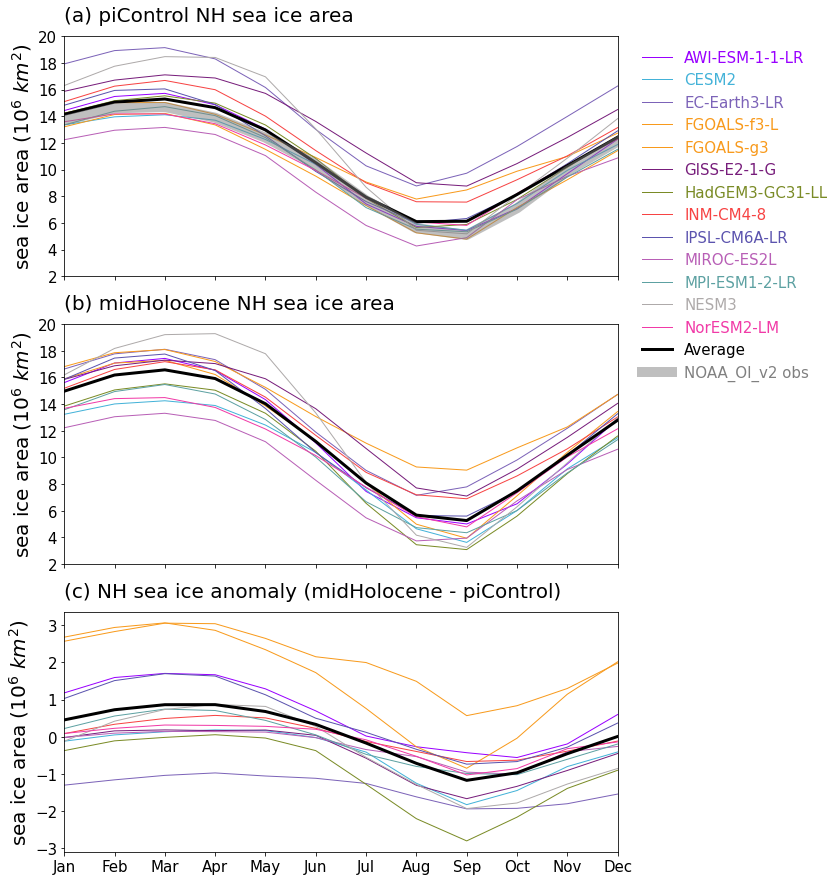

In [15]:
def subplotting1(title,data,modellist): 
    month = [1,2,3,4,5,6,7,8,9,10,11,12]
    model,r,g,b = information('PMIP4','midHolocene')
    plt.title(title,fontsize=20,loc='left',pad=15)
    plt.xlim([1,12])
    for i,m in enumerate(model):
        if m in modellist:
            plt.plot(month,data[m],color=[r[i],g[i],b[i]],lw=1,label=m)
    plt.plot(month,data['average'],color='k',lw=3,label='Average')
    yylabel='sea ice area ($10^{6}$ ${km^2}$)'
    plt.ylabel(yylabel,fontsize=20)
    
month=[1,2,3,4,5,6,7,8,9,10,11,12]
month1=['','','','','','','','','','','','']
month2=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

# plotting
plt.figure(figsize=(12,15))
gs = gridspec.GridSpec(3,2,height_ratios=[1,1,1],width_ratios=[10,1])
plt.subplot(gs[0])
subplotting1('(a) piControl NH sea ice area',nh_ice_pi,nh_model)
plt.ylim([2,20])
plt.xticks(month,month1,fontsize=15)
plt.yticks(fontsize=15)
plt.plot(month,NOAA_n,color='grey',alpha=0.5,lw=10,label='NOAA_OI_v2 obs')
leg=plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left',edgecolor='None',facecolor='None', borderaxespad=0.5,fontsize=15)
for line, text in zip(leg.get_lines(), leg.get_texts()):
    text.set_color(line.get_color())


plt.subplot(gs[2])
subplotting1('(b) midHolocene NH sea ice area',nh_ice_mh,nh_model)
plt.ylim([2,20])
plt.plot(month,nhmhave,color='k',lw=3,label='MMM')
plt.xticks(month,month1,fontsize=15)
plt.yticks(fontsize=15)

plt.subplot(gs[4])
subplotting1('(c) NH sea ice anomaly (midHolocene - piControl)',nh_ice_change,nh_model)
plt.plot(month,diffave,color='k',lw=3,label='MMM')
plt.xticks(month,month2,fontsize=15)
plt.yticks(fontsize=15)
#xxlabel='Month' 
#plt.xlabel(xxlabel,fontsize=15)


# Section 3: NAF expansion


In [57]:
# This function outputs lat. averaged monsoon summer rain rate over northern Africa
def calculation_ensemble_naf_expansion(pmip_v,experiment_name): 
    variable_name='monsoon_summer_rainrate'
    model_list = []
    DATA = {}
    lat=np.arange(-89.5,90,1)
    LL=lat[90:120]
    DATA['lat'] = LL
    var_dict = ensemble_members_dict(variable_name,experiment_name)
    grid_1x1 = xr.Dataset({'lat': (['lat'], np.arange(-89.5, 90., 1.0)),
                         'lon': (['lon'], np.arange(-179.5, 180, 1.0))})
    for gcm in var_dict:
            if gcm in pmip[pmip_v]:
                model_list.append(gcm)              
                expt_file = xr.open_dataset(var_dict.get(gcm),decode_times=False)
                var = expt_file[variable_name]
                this_regridder = xe.Regridder(expt_file,grid_1x1,'bilinear', reuse_weights=False,periodic=True) 
                var_1x1 = this_regridder(var)               
                naf_pr = var_1x1[90:120,160:210]
                ave = list(np.average(naf_pr,axis=1))
                DATA[gcm] = ave
    return model_list,DATA
                

In [60]:

mh_model,mh_naf_rain = calculation_ensemble_naf_expansion('PMIP4','midHolocene')
#lig_model,lig_naf_rain = calculation_ensemble_naf_expansion('PMIP4','lig127k')
pi_model,pi_naf_rain = calculation_ensemble_naf_expansion('PMIP4','piControl')

In [61]:
from scipy.interpolate import interp1d
from scipy import interpolate
# This function calculates the latitude where monsoon_summer_rainrate = 2 mm/day
def NAFexpansion(data1,modellist1):
    y1=data1['lat']
    LAT={}
    for m in modellist1:       
        x1=data1[m]
        f1= interp1d(x1, y1, kind='linear')
        x2=[2]
        l1=f1(x2)
        LAT[m]=l1[0]
    return LAT

In [ ]:
mh_naf = NAFexpansion(mh_naf_rain,mh_model)
lig_naf = NAFexpansion(lig_naf_rain,lig_model)
pi_naf = NAFexpansion(pi_naf_rain,pi_model)

### Plotting 
Author saved the output from above, and then manually created a file to plot the following figure.  

In [9]:
fname='plotting_data/PMIP4_NAF_Expansion.csv'
mh_naf=pd.read_csv(fname,skipinitialspace=True,header=0)['mh']
pi_naf=pd.read_csv(fname,skipinitialspace=True,header=0)['pi']
lig_naf=pd.read_csv(fname,skipinitialspace=True,header=0)['lig']
model=pd.read_csv(fname,skipinitialspace=True,header=0)['model']
number=pd.read_csv(fname,skipinitialspace=True,header=0)['number']
c_r=pd.read_csv(fname,skipinitialspace=True,header=0)['ipcc_r']
c_g=pd.read_csv(fname,skipinitialspace=True,header=0)['ipcc_g']
c_b=pd.read_csv(fname,skipinitialspace=True,header=0)['ipcc_b']
dlig=lig_naf-pi_naf
dmh=mh_naf-pi_naf

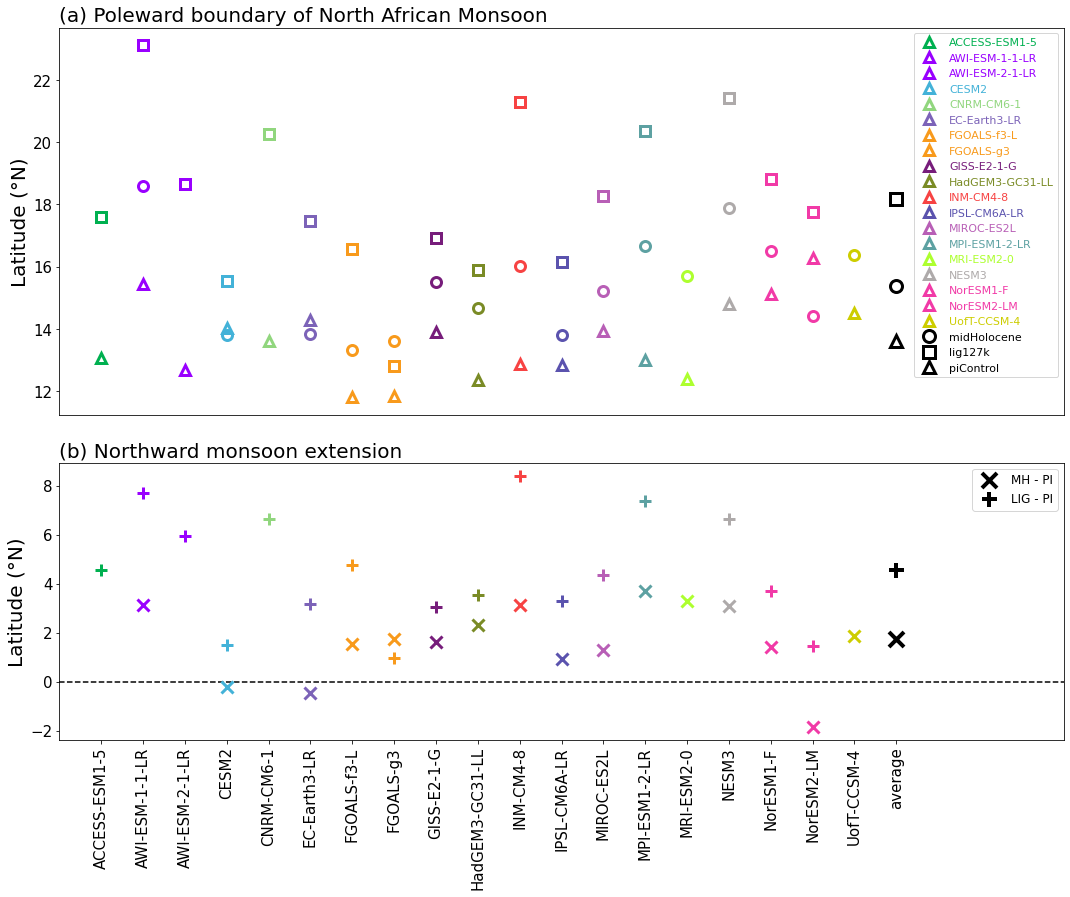

In [33]:
plt.figure(figsize=(18,15))
gs = gridspec.GridSpec(3, 1, height_ratios=[7,5,1]) 



plt.subplot(gs[0])
plt.title('(a) Poleward boundary of North African Monsoon',loc='left',fontsize=20)
plt.xlim([0,24])

for i,m in enumerate(model):
    if i < 19:
        plt.plot(number[i],mh_naf[i],marker='o',color=(c_r[i],c_g[i],c_b[i]),fillstyle='none',mew=3, ms=10,linestyle='None')
        plt.plot(number[i],lig_naf[i],marker='s',color=(c_r[i],c_g[i],c_b[i]),fillstyle='none',mew=3, ms=10,linestyle='None')
        plt.plot(number[i],pi_naf[i],marker='^',color=(c_r[i],c_g[i],c_b[i]),fillstyle='none',mew=3, ms=10,linestyle='None',label=m)
    # define labels
    if i == 19:
        plt.plot(number[i],mh_naf[i],marker='o',color=(c_r[i],c_g[i],c_b[i]),fillstyle='none',mew=3, ms=12,linestyle='None',label="midHolocene")
        plt.plot(number[i],lig_naf[i],marker='s',color=(c_r[i],c_g[i],c_b[i]),fillstyle='none',mew=3, ms=12,linestyle='None',label="lig127k")
        plt.plot(number[i],pi_naf[i],marker='^',color=(c_r[i],c_g[i],c_b[i]),fillstyle='none',mew=3, ms=12,linestyle='None',label="piControl")
leg=plt.legend(fontsize=11)
for line, text in zip(leg.get_lines(), leg.get_texts()):
    text.set_color(line.get_color())
plt.xticks([])
plt.yticks(fontsize=15)
plt.ylabel('Latitude (%sN)'%chr(176),fontsize=20)


plt.subplot(gs[1])
plt.title('(b) Northward monsoon extension',loc='left',fontsize=20)
plt.xlim([0,24])
plt.axhline(y=0,color='k',linestyle="--")
#plt.axhline(xmin=0,xmax=20,y=10,color='k',linestyle="-",linewidth=1.5)

for i,m in enumerate(model):
    if i < 19:
        plt.plot(number[i],dlig[i],marker='+',color=(c_r[i],c_g[i],c_b[i]),mew=3, ms=12,linestyle='None')
        plt.plot(number[i],dmh[i],marker='x',color=(c_r[i],c_g[i],c_b[i]),mew=3, ms=12,linestyle='None')
    # define labels
    if i == 19:
        plt.plot(number[i],dmh[i],marker='x',color=(c_r[i],c_g[i],c_b[i]),mew=4, ms=15,linestyle='None',label='MH - PI')
        plt.plot(number[i],dlig[i],marker='+',color=(c_r[i],c_g[i],c_b[i]),mew=4, ms=15,linestyle='None',label="LIG - PI")
        
leg=plt.legend(fontsize=12)
plt.yticks(fontsize=15)
plt.ylabel('Latitude (%sN)'%chr(176),fontsize=20)
plt.xticks(number,model,rotation=90,fontsize=15)


# Section 4: changes in regional monsoons

In [ ]:
#Define monsoon names
monsoonlist=['NAMS','NAF','SAS','EAS','SAMS','SAF','AUSMC']
#NAMS:North American Monsoon System
#NAF: North Africa
#SAS Southern Asia 
#EAS: East Asia Summer 
#SAMS: South America Monsoon System
#SAF: Southern Asia
#AUSMC: Aurtralian-Maritime Continent

In [ ]:
# This function outputs the data used to plot panel c below
def monsoon_cal_change(monsoon_name,experiment_name,pmip_v):
    data={}
    rainfall_name='monsoon_rain_%s' %monsoon_name
    area_name='monsoon_area_%s' %monsoon_name
    A_dict=ensemble_members_dict(rainfall_name,experiment_name)
    B_dict=ensemble_members_dict(rainfall_name,'piControl')
    for gcm in A_dict:
        if gcm in B_dict:
            if gcm in pmip[pmip_v]:
                expt_a_file=xr.open_dataset(A_dict.get(gcm),decode_times=False)
                expt_rain=expt_a_file[rainfall_name]
                expt_mean_rain=np.nanmean(expt_rain)
                expt_std_rain=np.nanstd(expt_rain)
                expt_area=expt_a_file[area_name]
                expt_mean_area=np.nanmean(expt_area)
                expt_std_area=np.nanstd(expt_area)
                expt_water=expt_rain*expt_area
                expt_mean_water=np.nanmean(expt_water)
                expt_b_file=xr.open_dataset(B_dict.get(gcm),decode_times=False)
                pi_rain=expt_b_file[rainfall_name]
                pi_mean_rain=np.nanmean(pi_rain)
                pi_std_rain=np.nanstd(pi_rain)
                pi_area=expt_b_file[area_name]
                pi_mean_area=np.nanmean(pi_area)
                pi_std_area=np.nanstd(pi_area)
                pi_water=pi_rain*pi_area
                pi_mean_water=np.nanmean(pi_water)
                pav=(expt_mean_rain-pi_mean_rain)*100/pi_mean_rain
                psd=(expt_std_rain-pi_std_rain)*100/pi_std_rain
                aav=(expt_mean_area-pi_mean_area)*100/pi_mean_area
                asd=(expt_std_area-pi_std_area)*100/pi_std_area
                water=(expt_mean_water-pi_mean_water)*100/pi_mean_water
                data[gcm]=[pav,psd,aav,asd,water]
    f3='%s_%s.csv' %(pmip_v,monsoon_name)
    DD=pd.DataFrame(data)
    DD.to_csv(f3)
    return data




In [2]:
# some plotting functions
def monsoonplotting(pos,p,monsoon,marker):
    filename = '%s_%s.csv'%(p,monsoon)
    data = pd.read_csv(filename,skipinitialspace=True,header=0)
    mlist=data.columns
    model,r,g,b = information(p)  
    if p == 'PMIP4':
        for i,m in enumerate(model):
            if m in mlist:
                plt.plot(pos,data[m],marker=marker,color=(r[i],g[i],b[i]),fillstyle='none',mew=2, ms=10,linestyle='None',label=m)
        plt.plot(pos,data['average'],marker='x',color='k',mew=3, ms=20,linestyle='None',label='MMM')
    if p == 'PMIP3':
        plt.plot(pos,data['BCC-CSM1-1'],marker=marker,color=(r[0],g[0],b[0]),fillstyle='none',mew=2, ms=10,linestyle='None',label= 'PMIP3 models')
        for i,m in enumerate(model):
            if m in mlist:
                plt.plot(pos,data[m],marker=marker,color=(r[i],g[i],b[i]),fillstyle='none',mew=2, ms=10,linestyle='None')
        plt.plot(pos,data['average'],marker='x',color='k',mew=3, ms=20,linestyle='None')


def plotting_mon(var):    
    pos1=[0.3,1.3,2.3,3.3,4.3]
    pos2=[0.7,1.7,2.7,3.7,4.7]
    pos3=[0.5,1.5,2.5,3.5,4.5]
    var_name=['pav','psd','aav','asd','totwater']
    plt.figure(figsize=(14,7))
    gs = gridspec.GridSpec(1, 2, width_ratios=[8, 1]) 
    plt.subplot(gs[0])
    plt.title(var,fontsize=30,pad=15)
    plt.xlim([0,5])
    lines=[1,2,3,4]
    plt.axhline(y=0,color='black',linestyle="--",linewidth=2)
    for l in lines:
        plt.axvline(l,color='grey',linestyle="--",linewidth=1.5)
    monsoonplotting(pos1,'PMIP3',var,'s')
    monsoonplotting(pos2,'PMIP4',var,'o')
    plt.tick_params(labelsize=15)
    plt.xticks(pos3,var_name,fontsize=25)
    plt.ylabel('% of change',fontsize=20)
    leg=plt.legend(bbox_to_anchor=(1,1.02),fontsize=15,facecolor='white')
    for line, text in zip(leg.get_lines(), leg.get_texts()):
        text.set_color(line.get_color())
    #plt.savefig('%s.png'%var)
    #plt.savefig('%s.pdf'%var)


In [5]:
# This function uses saved results as input
def monsoon_new_plotting(monsoon,p):
    filenameobs = 'plotting_data/GPCP_%s.csv'%(monsoon)
    dataobs = pd.read_csv(filenameobs,skipinitialspace=True,header=0)['obs']   
    plt.figure(figsize=(10,15))
    gs = gridspec.GridSpec(4,1,height_ratios=[2,2,1,4]) 
    filename1 = 'plotting_data/%s_%s_mh.csv'%(p,monsoon)
    data1 = pd.read_csv(filename1,skipinitialspace=True,header=0)
    mlist1=data1.columns
    filename2 = 'plotting_data/%s_%s_pi.csv'%(p,monsoon)
    data2 = pd.read_csv(filename2,skipinitialspace=True,header=0)
    mlist2=data2.columns
    model,r,g,b = information(p)
    number=np.arange(1,20,1)
    num1=np.arange(1,17,1)
    num2=[18,19]
    xlabel1=['',
               '',
               '',
               '',
               '',
               '',
               '',
               '',
               '',
               '',
               '',
               '',
               '',
               '',
               '',
               '','','','']

    xlabel2=['AWI-ESM-1-1-LR',
                   'CESM2',
                   'EC-Earth3-LR',
                   'FGOALS-f3-L',
                   'FGOALS-g3',
                   'GISS-E2-1-G',
                   'HadGEM3-GC31-LL',
                   'INM-CM4-8',
                   'IPSL-CM6A-LR',
                   'MIROC-ES2L',
                   'MPI-ESM1-2-LR',
                   'MRI-ESM2-0',
                   'NESM3',
                   'NorESM1-F',
                   'NorESM2-LM',
                   'UofT-CCSM-4','','AVE','STD']
    # panel a
    plt.subplot(gs[0])
    plt.title('(a) Rainfall over %s domain'%monsoon,loc='left',fontsize=15)
    plt.axhline(y=0,color='black',linestyle="--",linewidth=2)
    plt.axhline(y=dataobs[0],color='red',linestyle="dotted",linewidth=2)
    plt.xlim([0,20])
    for i,m in enumerate(model):
        plt.plot(number[i],data1[m][0],marker='o',color=(r[i],g[i],b[i]),fillstyle='none',mew=3, ms=10,linestyle='None')
        plt.plot(number[i],data2[m][0],marker='^',color=(r[i],g[i],b[i]),fillstyle='none',mew=3, ms=10,linestyle='None')
        plt.plot(number[i],data1[m][0]-data2[m][0],marker='x',color=(r[i],g[i],b[i]),mew=3, ms=10,linestyle='None')
    plt.plot(18,data1['ave'][0],marker='o',color='k',fillstyle='none',mew=3, ms=12,linestyle='None',label='MH')
    plt.plot(18,data2['ave'][0],marker='^',color='k',fillstyle='none',mew=3, ms=12,linestyle='None',label='PI')
    plt.plot(18,data1['ave'][0]-data2['ave'][0],marker='x',color='k',mew=3, ms=12,linestyle='None',label='MH - PI')
    plt.plot(19,data1['std'][0],marker='o',color='k',fillstyle='none',mew=3, ms=12,linestyle='None')
    plt.plot(19,data2['std'][0],marker='^',color='k',fillstyle='none',mew=3, ms=12,linestyle='None')
    plt.plot(19,data1['std'][0]-data2['std'][0],marker='x',color='k',mew=3, ms=12,linestyle='None')
    plt.yticks(fontsize=10)
    plt.ylabel('mm/day',fontsize=12)
    plt.xticks(number,xlabel1,rotation=90,fontsize=12)
    # panel b
    plt.subplot(gs[1])
    plt.title('(b) Area of %s domain'%monsoon,loc='left',fontsize=15)
    plt.axhline(y=0,color='black',linestyle="--",linewidth=2)
    plt.axhline(y=dataobs[2]/10e5,color='red',linestyle="dotted",linewidth=2,label='GPCP obs')
    plt.xlim([0,20])
    for i,m in enumerate(model):
        plt.plot(number[i],data1[m][2]/10e5,marker='o',color=(r[i],g[i],b[i]),fillstyle='none',mew=3, ms=10,linestyle='None')
        plt.plot(number[i],data2[m][2]/10e5,marker='^',color=(r[i],g[i],b[i]),fillstyle='none',mew=3, ms=10,linestyle='None')
        plt.plot(number[i],data1[m][2]/10e5-data2[m][2]/10e5,marker='x',color=(r[i],g[i],b[i]),mew=3, ms=10,linestyle='None')
    plt.plot(18,data1['ave'][2]/10e5,marker='o',color='k',fillstyle='none',mew=3, ms=12,linestyle='None',label='MH')
    plt.plot(18,data2['ave'][2]/10e5,marker='^',color='k',fillstyle='none',mew=3, ms=12,linestyle='None',label='PI')
    plt.plot(18,data1['ave'][2]/10e5-data2['ave'][2]/10e5,marker='x',color='k',mew=3, ms=12,linestyle='None',label='MH - PI')
    plt.plot(19,data1['std'][2]/10e5,marker='o',color='k',fillstyle='none',mew=3, ms=12,linestyle='None')
    plt.plot(19,data2['std'][2]/10e5,marker='^',color='k',fillstyle='none',mew=3, ms=12,linestyle='None')
    plt.plot(19,data1['std'][2]/10e5-data2['std'][2]/10e5,marker='x',color='k',mew=3, ms=12,linestyle='None')
    leg=plt.legend(bbox_to_anchor=(0.98,-0.23),loc='upper right',facecolor='white')
    plt.yticks(fontsize=10)
    plt.ylabel('10$^{6}$km$^{2}$',fontsize=12)
    plt.xticks(number,xlabel2,rotation=90,fontsize=12)
    # panel c
    plt.subplot(gs[3])
    pos1=[0.3,1.3,2.3,3.3,4.3]
    pos2=[0.7,1.7,2.7,3.7,4.7]
    pos3=[0.5,1.5,2.5,3.5,4.5]
    var_name=['pav','psd','aav','asd','totwater']
    plt.title('(c) Relative changes in %s'%monsoon,loc='left',fontsize=15)
    plt.xlim([0,6.7])
    lines=[1,2,3,4,5]
    plt.axhline(y=0,color='black',linestyle="--",linewidth=2)
    for l in lines:
        plt.axvline(l,color='grey',linestyle="--",linewidth=1.5)
    monsoonplotting(pos1,'PMIP3',monsoon,'s')
    monsoonplotting(pos2,'PMIP4',monsoon,'o')
    plt.tick_params(labelsize=10)
    plt.xticks(pos3,var_name,fontsize=15)
    plt.ylabel('% of change',fontsize=12)
    leg=plt.legend(loc='upper right',facecolor='white')
    for line, text in zip(leg.get_lines(), leg.get_texts()):
        text.set_color(line.get_color())
    #plt.savefig('%s.png'%monsoon)
    #plt.savefig('%s.pdf'%monsoon)

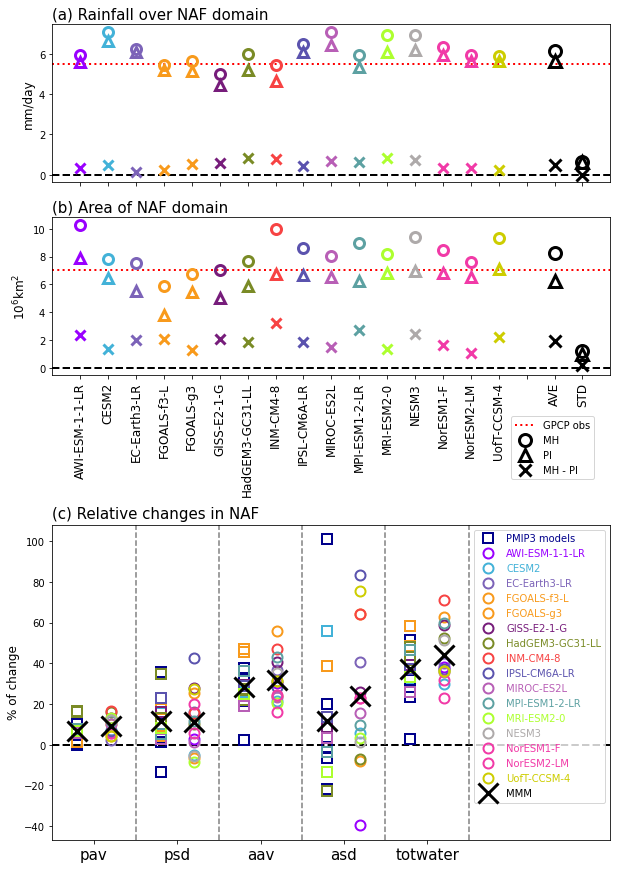

In [8]:
monsoon_new_plotting("NAF",'PMIP4')